<a href="https://colab.research.google.com/github/javierbaldrich/511_dogs/blob/main/dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog breed classification

In this notebook we will implement transfer learning using the Keras library to crete a submission file for the [Dog Breed Identification](https://www.kaggle.com/competitions/dog-breed-identification) Kaggle competition.

We will use the [Xception](https://arxiv.org/pdf/1610.02357.pdf) pre-trained model [that Keras offers out-of-the-box](https://keras.io/api/applications/xception/).

To start, we import some necessary resources.

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.applications import Xception
from keras.optimizers import *

We also define our training and test dataset.

In [ ]:
# Directory definitions
root_dir = os.path.abspath(os.path.dirname(__file__))
train_dir = os.path.join(root_dir, 'train')
train_df = pd.read_csv(os.path.join(root_dir, 'labels.csv'))
test_dir = os.path.join(root_dir, 'test')
test_df = pd.read_csv(os.path.join(root_dir, 'sample_submission.csv'))

In [ ]:
# Training dataset characteristics
train_n = len(train_df)
breeds = set(train_df['breed'])
breeds_n = len(breeds)

In [ ]:
# These two dictionaries will be used to enconde and decode breeds into and out of breeds_n-length orthogonal arrays which will be the actual response of the model
breed_to_num = dict(zip(breeds, range(breeds_n)))
num_to_breed = dict(zip(range(breeds_n), breeds))

In [ ]:
# We will do some basic iteration over the training set to retrieve the max and min sizes as well as the brigtness/darkness
# This will help us remove images that might be pernicious for training
train_img_names = train_df['id'].astype(str).to_numpy()
pixels = 0
max_size = [0, None]
min_size = [np.inf, None]
image_color = {}
for img_name in train_img_names:
    img_array = mpimg.imread(os.path.join(train_dir, img_name + '.jpg'))
    img_size = 1
    for dim_size in img_array.shape:
        img_size *= dim_size
    if img_size > max_size[0]:
        max_size = [img_size, img_array.shape]
    if img_size < min_size[0]:
        min_size = [img_size, img_array.shape]
    image_color[img_name] = np.sum(img_array) / img_size
print(f'The training dataset consists of {len(train_img_names)} RGB images ranging in size from {max_size[1]} to {min_size[1]}.')



```
The training dataset consists of 10222 RGB images ranging in size from (2448, 3264, 3) to (102, 120, 3).
```



In [ ]:
# We pull and plot the top .2% brightest and darkest images
sorted_items = sorted(image_color.items(), key=lambda x: x[1], reverse=True)
top_index = max(0, int(len(sorted_items) * 0.002))
brightest_pictures = sorted_items[:top_index]
sorted_items = sorted(image_color.items(), key=lambda x: x[1], reverse=False)
top_index = max(0, int(len(sorted_items) * 0.002))
darkest_pictures = sorted_items[:top_index]
for img_set in [brightest_pictures, darkest_pictures]:
    n_images = len(img_set)
    cols = int(np.ceil(np.sqrt(n_images)))
    rows = int(np.ceil(n_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()
    for index, (img, ax) in enumerate(zip(img_set, axes)):
        ax.imshow(mpimg.imread(os.path.join(train_dir, img[0] + '.jpg'))) 
        plt.title(f'Image {index + 1}')
        plt.axis('off')
    plt.show()

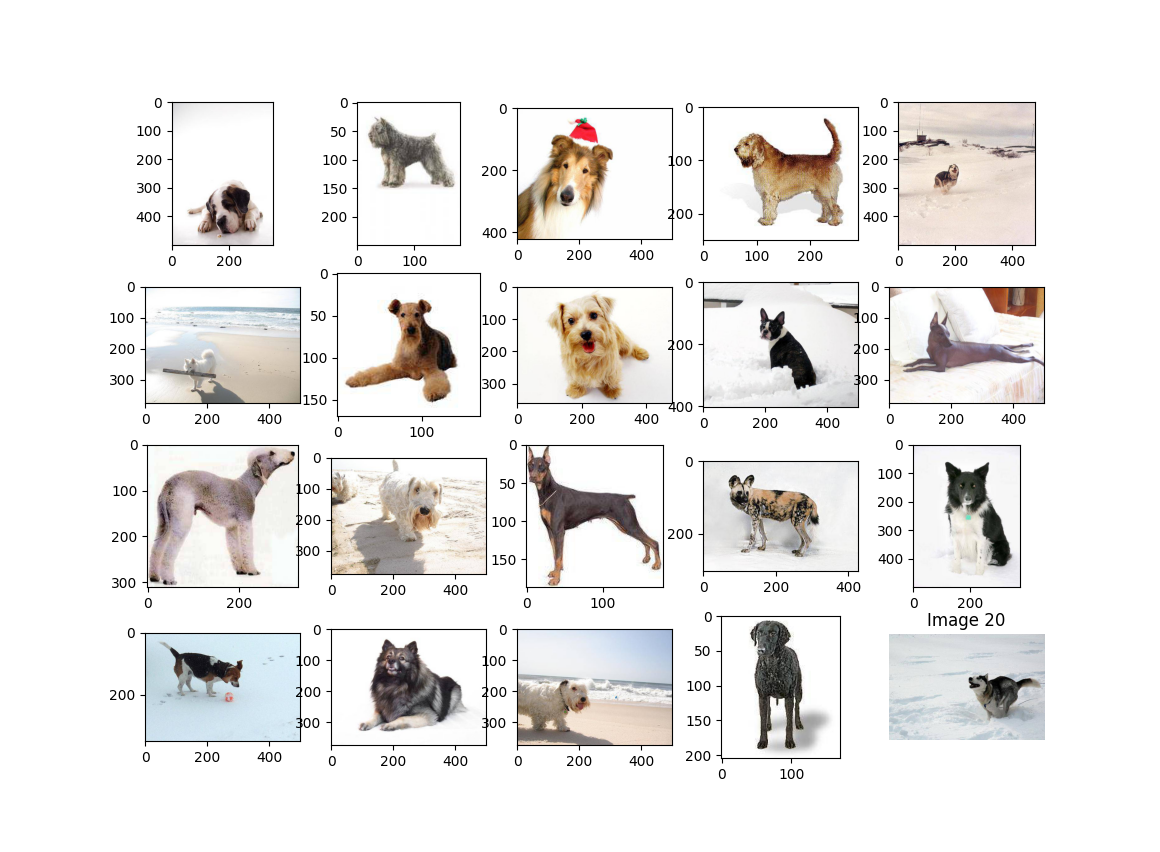


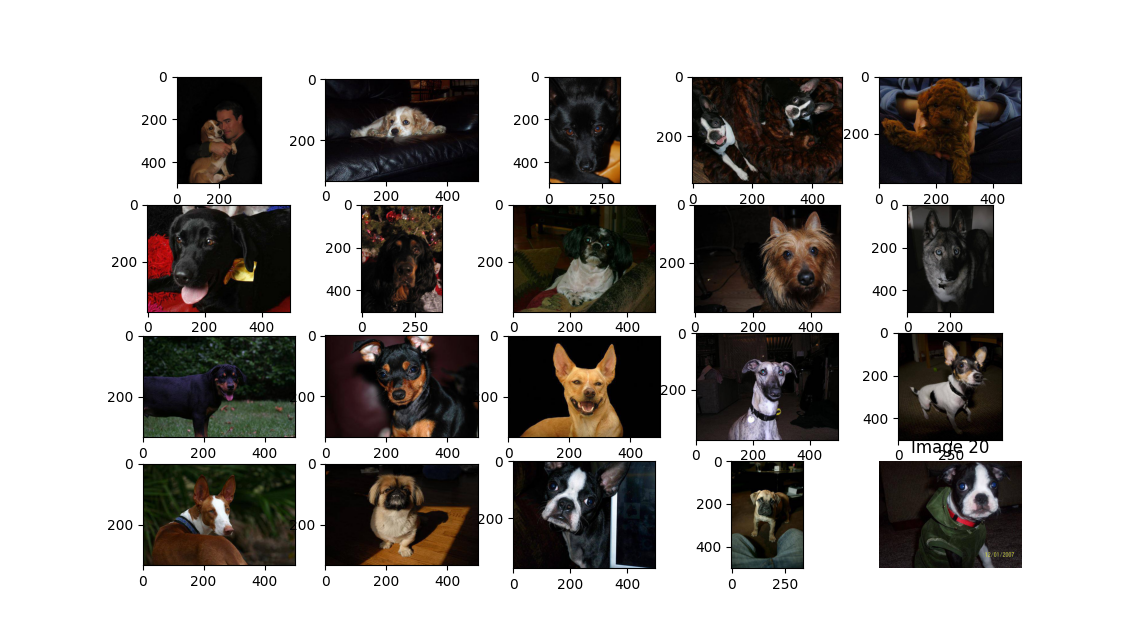

There are no images to remove due to excessive brightness/darkness: we can proceed.

In [1]:
# We plot the breed distribution of the training dataset.
breeds = pd.value_counts(train_df['breed'])
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(breeds.index, breeds.values)
ax.set_title('Breed distribution')
ax.set_xlabel('Breeds')
ax.set_ylabel('Number of training instances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

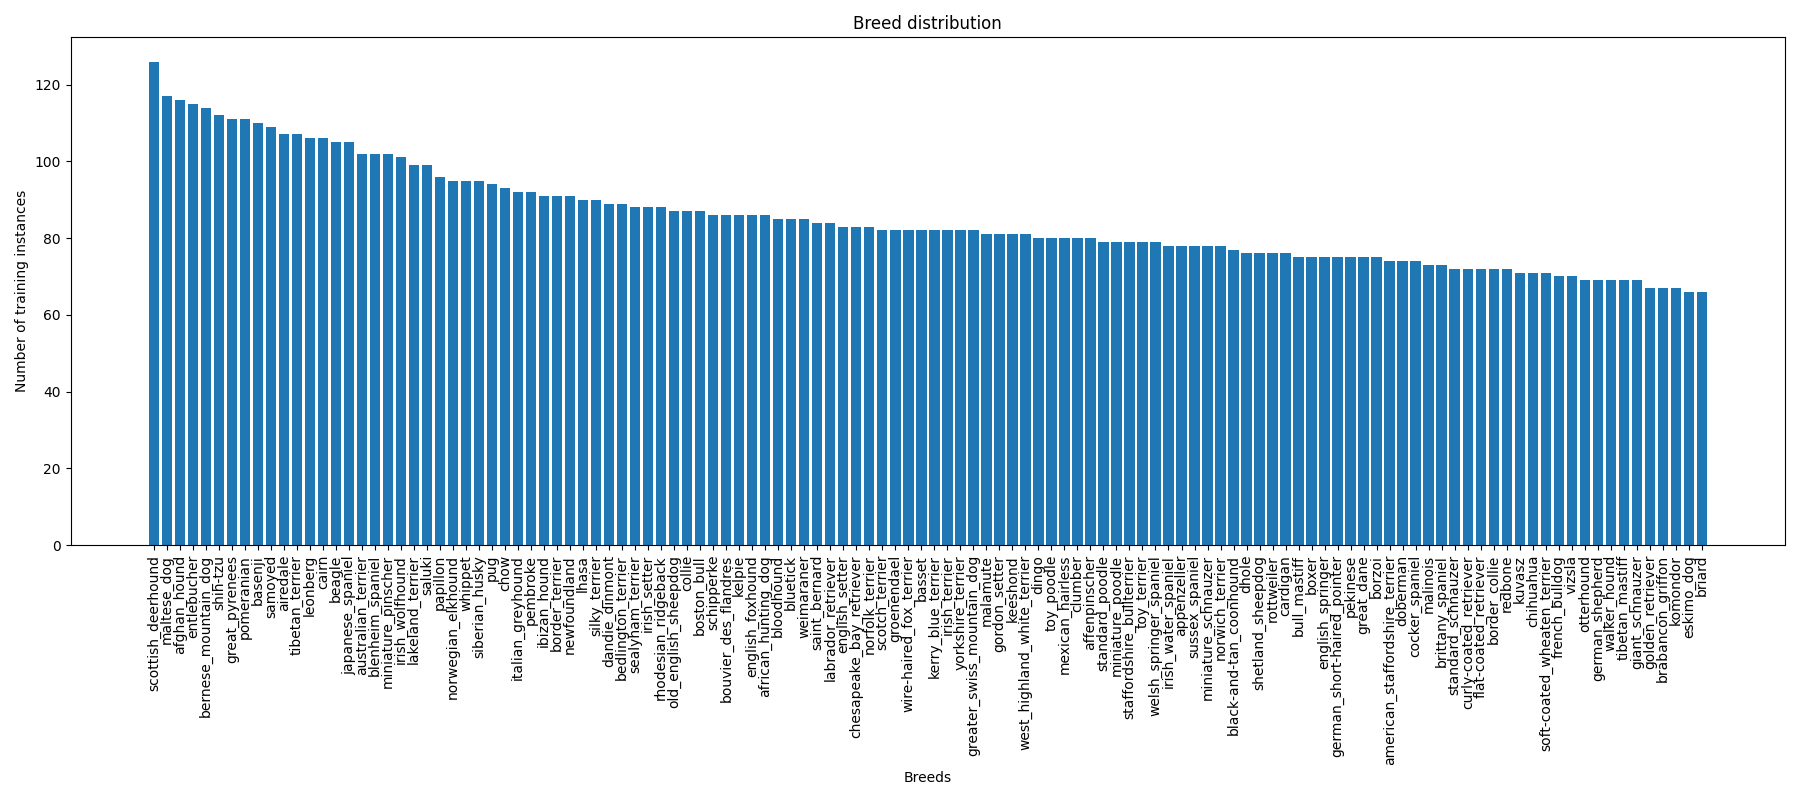

In [ ]:
# Setting the width and height to which all images will be resized and creating the design matrix X (train_n, width, height, 3) and the response y (train_n, breeds_n)
width = 299
height = 299
X = np.zeros((train_n, width, height, 3), dtype=np.uint8)
y = np.zeros((train_n, breeds_n), dtype=np.uint8)
for i in range(train_n):
    X[i] = cv2.resize(cv2.cvtColor(cv2.imread(f"train/{train_df['id'][i]}.jpg"), cv2.COLOR_BGR2RGB), (width, height))
    y[i][breed_to_num[train_df['breed'][i]]] = 1

In [ ]:
# Pre-defining the NON TRAINABLE top model, the image augmentation layer (horizontal flipping and rotation) and re-scaling to (-1, 1) 
base_model = Xception(
    weights="imagenet",
    input_shape=(299, 299, 3),
    include_top=False,
) 
base_model.trainable = False
augmentation_layer = Sequential(
    [RandomFlip("horizontal"), RandomRotation(0.1),]
)
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)

# Defining the classification model
inputs = Input((width, height, 3))
x = augmentation_layer(inputs)
x = scale_layer(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(breeds_n, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Initial trainig 
top_train = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.125)



```
Epoch 1/5
280/280 [==============================] - 45s 147ms/step - loss: 1.3658 - accuracy: 0.7479 - val_loss: 0.3960 - val_accuracy: 0.9085
Epoch 2/5
280/280 [==============================] - 40s 141ms/step - loss: 0.4586 - accuracy: 0.8723 - val_loss: 0.3142 - val_accuracy: 0.9077
Epoch 3/5
280/280 [==============================] - 40s 142ms/step - loss: 0.3771 - accuracy: 0.8880 - val_loss: 0.2898 - val_accuracy: 0.9131
Epoch 4/5
280/280 [==============================] - 40s 142ms/step - loss: 0.3314 - accuracy: 0.8971 - val_loss: 0.2712 - val_accuracy: 0.9194
Epoch 5/5
280/280 [==============================] - 40s 142ms/step - loss: 0.3059 - accuracy: 0.9054 - val_loss: 0.2746 - val_accuracy: 0.9131
```



In [ ]:
# Plotting initial training performance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(top_train.history['loss'])
plt.plot(top_train.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(top_train.history['accuracy'])
plt.plot(top_train.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

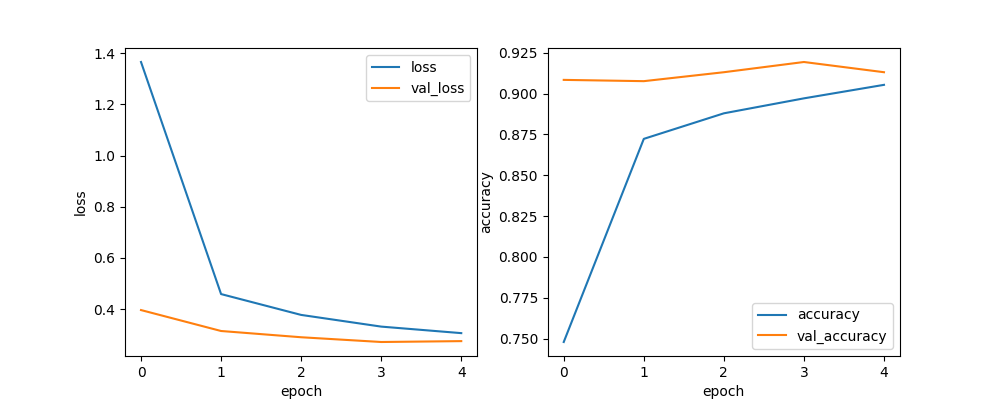

In [ ]:
# Fine tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(1e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fine_tune = model.fit(X, y, batch_size=32, epochs=20, validation_split=0.125)




```
Epoch 1/20
280/280 [==============================] - 85s 290ms/step - loss: 0.2564 - accuracy: 0.9218 - val_loss: 0.2726 - val_accuracy: 0.9124
Epoch 2/20
280/280 [==============================] - 80s 287ms/step - loss: 0.2517 - accuracy: 0.9244 - val_loss: 0.2711 - val_accuracy: 0.9116
Epoch 3/20
280/280 [==============================] - 80s 285ms/step - loss: 0.2514 - accuracy: 0.9206 - val_loss: 0.2698 - val_accuracy: 0.9108
Epoch 4/20
280/280 [==============================] - 80s 286ms/step - loss: 0.2468 - accuracy: 0.9214 - val_loss: 0.2690 - val_accuracy: 0.9108
Epoch 5/20
280/280 [==============================] - 81s 288ms/step - loss: 0.2361 - accuracy: 0.9254 - val_loss: 0.2683 - val_accuracy: 0.9116
Epoch 6/20
280/280 [==============================] - 80s 287ms/step - loss: 0.2388 - accuracy: 0.9241 - val_loss: 0.2676 - val_accuracy: 0.9116
Epoch 7/20
280/280 [==============================] - 80s 285ms/step - loss: 0.2308 - accuracy: 0.9267 - val_loss: 0.2672 - val_accuracy: 0.9108
Epoch 8/20
280/280 [==============================] - 80s 286ms/step - loss: 0.2285 - accuracy: 0.9296 - val_loss: 0.2666 - val_accuracy: 0.9116
Epoch 9/20
280/280 [==============================] - 81s 289ms/step - loss: 0.2306 - accuracy: 0.9254 - val_loss: 0.2662 - val_accuracy: 0.9108
Epoch 10/20
280/280 [==============================] - 81s 289ms/step - loss: 0.2216 - accuracy: 0.9316 - val_loss: 0.2659 - val_accuracy: 0.9108
Epoch 11/20
280/280 [==============================] - 81s 288ms/step - loss: 0.2271 - accuracy: 0.9288 - val_loss: 0.2657 - val_accuracy: 0.9116
Epoch 12/20
280/280 [==============================] - 80s 286ms/step - loss: 0.2265 - accuracy: 0.9258 - val_loss: 0.2655 - val_accuracy: 0.9124
Epoch 13/20
280/280 [==============================] - 80s 286ms/step - loss: 0.2211 - accuracy: 0.9283 - val_loss: 0.2655 - val_accuracy: 0.9124
Epoch 14/20
280/280 [==============================] - 81s 289ms/step - loss: 0.2210 - accuracy: 0.9271 - val_loss: 0.2653 - val_accuracy: 0.9131
Epoch 15/20
280/280 [==============================] - 80s 287ms/step - loss: 0.2213 - accuracy: 0.9287 - val_loss: 0.2651 - val_accuracy: 0.9139
Epoch 16/20
280/280 [==============================] - 80s 285ms/step - loss: 0.2161 - accuracy: 0.9316 - val_loss: 0.2648 - val_accuracy: 0.9139
Epoch 17/20
280/280 [==============================] - 80s 286ms/step - loss: 0.2107 - accuracy: 0.9315 - val_loss: 0.2647 - val_accuracy: 0.9124
Epoch 18/20
280/280 [==============================] - 81s 288ms/step - loss: 0.2142 - accuracy: 0.9296 - val_loss: 0.2648 - val_accuracy: 0.9124
Epoch 19/20
280/280 [==============================] - 80s 287ms/step - loss: 0.2138 - accuracy: 0.9298 - val_loss: 0.2647 - val_accuracy: 0.9116
Epoch 20/20
280/280 [==============================] - 81s 288ms/step - loss: 0.2084 - accuracy: 0.9320 - val_loss: 0.2649 - val_accuracy: 0.9124
```



In [ ]:
# Plotting fine tuning performance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune.history['loss'])
plt.plot(fine_tune.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(fine_tune.history['accuracy'])
plt.plot(fine_tune.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

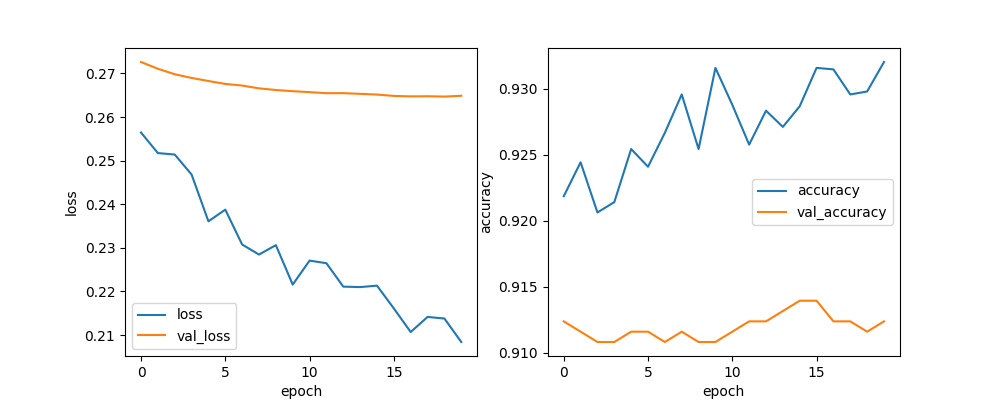

In [ ]:
# Prediction
test_n = len(test_df)
X_test = np.zeros((test_n, width, height, 3), dtype=np.uint8)
for i in range(test_n):
    X_test[i] = cv2.resize(cv2.cvtColor(cv2.imread(f"test/{test_df['id'][i]}.jpg"), cv2.COLOR_BGR2RGB), (width, height))
y_test = model.predict(X_test)
y_test_df = pd.DataFrame(y_test)
y_test_df.rename(columns=num_to_breed, inplace=True)
y_test_df['id'] = test_df['id']
y_test_df.to_csv('submission.csv', index=False)